In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
DATA_DIR = "data/raw"
PROCESSED_DIR = "data/processed"

### 1. Prep Dataset
---

In [3]:
data_df = pd.read_csv(os.path.join(DATA_DIR, "Dataset.csv")).iloc[:,:88].set_index("Code ID")
treatment_df = pd.read_csv(os.path.join(DATA_DIR, "Treatments.csv")).set_index("Code ID")

# Errors in input
# 2006097 - Cardiopulmonary symptom onset = 0026-01-01
# 2009206 - Cardiopulmonary symptom onset = 0001-01-01

samples_to_remove = [2006097, 2009206]

data_df = data_df.drop(samples_to_remove)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

In [4]:
# Add encoding variables
data_df['Amyloid type'] = data_df['Amyloid type'].apply(lambda x: utils.map_encoding(x, amyloid.enc_amyloid_type))
data_df['Sex'] = data_df['Sex'].apply(lambda x: utils.map_encoding(x, amyloid.enc_sex))
data_df['Ethnicity'] = data_df['Ethnicity'].apply(lambda x: utils.map_encoding(x, amyloid.enc_ethnicity))
data_df['Race'] = data_df['Race'].apply(lambda x: utils.map_encoding(x, amyloid.enc_race))
data_df['Education'] = data_df['Education'].apply(lambda x: utils.map_encoding(x, amyloid.enc_education))
data_df['Abdominal fat pad CR staining'] = data_df['Abdominal fat pad CR staining'].apply(lambda x: utils.map_encoding(x, amyloid.enc_staining))
data_df['Bone marrow CR staining'] = data_df['Bone marrow CR staining'].apply(lambda x: utils.map_encoding(x, amyloid.enc_staining))

for var in amyloid.amyloid_ros:
    data_df[var] = data_df[var].apply(lambda x: utils.map_encoding(x, amyloid.enc_ros))

data_df['Primary organ'] = data_df['Primary organ'].apply(lambda x: utils.map_encoding(x, amyloid.enc_organ))
data_df['Secondary organ'] = data_df['Secondary organ'].apply(lambda x: utils.map_encoding(x, amyloid.enc_organ))

for var in amyloid.amyloid_symptoms:
    data_df[var] = data_df[var].apply(lambda x: utils.map_encoding(x, amyloid.enc_descriptors))

data_df["SIFE M-component"] = data_df["SIFE M-component"].apply(lambda x: utils.map_encoding(x, amyloid.enc_m_components))
data_df["UIFE M-component"] = data_df["UIFE M-component"].apply(lambda x: utils.map_encoding(x, amyloid.enc_m_components))

data_df["Mayo  2004 cardiac biomarker staging"] = data_df["Mayo  2004 cardiac biomarker staging"].apply(lambda x: utils.map_encoding(x, amyloid.enc_mayo_2004))
data_df["BU (BNP-based) cardiac staging"] = data_df["BU (BNP-based) cardiac staging"].apply(lambda x: utils.map_encoding(x, amyloid.enc_bu_2019))

# Add eGFR
data_df = data_df.rename(columns={'Age at diagnosis (y)':'Age'})
data_df["eGFR"] = data_df.apply(lambda row: utils.compute_egfr(row['Creatinine'], row['Age'], row['Sex']=="female"),1)

# Add Renal Staging
data_df["Renal Stage (Palladini)"] = data_df.apply(utils.get_palladini_renal_stage, 1)

# Replace qVars with sCr
amyloid.qvars[amyloid.qvars.index("Creatinine")] = "eGFR"

# Censor
# Select either last visit or time of death, include time to event in months
data_df['status'] = np.where(data_df['Date of death'].notna(), 1, 0)
data_df['time'] = data_df[['Date of death','Date of last visit']].max(axis=1) - data_df['Date of diagnosis']
data_df['time'] = data_df['time'] / pd.Timedelta(days=365.25)

# Time from admission
data_df['time_from_admission'] = data_df[['Date of death','Date of last visit']].max(axis=1) - data_df['Date of admission to center']
data_df['time_from_admission'] = data_df['time_from_admission'] / pd.Timedelta(days=365.25)

# Add Eras
data_df["Era"] = data_df["Date of diagnosis"].apply(lambda x: utils.get_eras(x))

### 2. Prep Treatments
---

In [5]:
# Treatment dictionary
treatment_dict = {int(line.split(None, 1)[0]): line.split(None, 1)[1].strip() for line in amyloid.enc_treaments.strip().split('\n')}

# Treatment groups dictionary
# Split the string into lines
lines = amyloid.enc_treatment_groups.strip().split('\n')

# Create a dictionary from the lines
treatment_groups_dict = {}
for line in lines:
    treatment, numbers = line.split("\t")
    #print(treatment, "- ", numbers)
    numbers_list = [int(num) for num in numbers.split(',')]
    for num in numbers_list:
        treatment_groups_dict[num] = treatment.strip()

treatment_groups_dict[99] = 'Other'
treatment_df['treatment_eskd'] = treatment_df['Treatment code'].isin([51,52,54])

# Fix dates (2):
fix_dates = {"0020-09-23":"09/23/20", "0023-05-05":"05/05/23"}

for idx,row in treatment_df.iterrows():
    if row['Start date'] in fix_dates.keys():
        treatment_df.loc[idx,'Start date'] = fix_dates[row['Start date']]

# Fix Treatment Dates
treatment_df['treatment_name'] = treatment_df['Treatment code'].apply(lambda x: treatment_dict[x])
treatment_df['treatment_group'] = treatment_df['Treatment code'].apply(lambda x: treatment_groups_dict[x])
treatment_df['Date of diagnosis'] = pd.to_datetime(treatment_df['Date of diagnosis'], format="mixed")
treatment_df['Start date'] = pd.to_datetime(treatment_df['Start date'], format="mixed")
treatment_df['End date'] = pd.to_datetime(treatment_df['End date'], format="mixed")
treatment_df['Day 0 date'] = pd.to_datetime(treatment_df['Day 0 date'], format="mixed")

In [6]:
data_df.rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR, "dataset_processed.tsv"), sep='\t')
treatment_df.to_csv(os.path.join(PROCESSED_DIR, "treatments_processed.tsv"), sep='\t')

### 3. Explore
---

In [6]:
# select only AL amyloid
AL_df = data_df[data_df['Amyloid type'] == "AL"]

# Select for ones we know the LC isotype
AL_df = AL_df[AL_df['Kappa or lambda PCD'].notna()]

# Filter for rationale TTE
AL_df = AL_df[AL_df["time"] > 0]

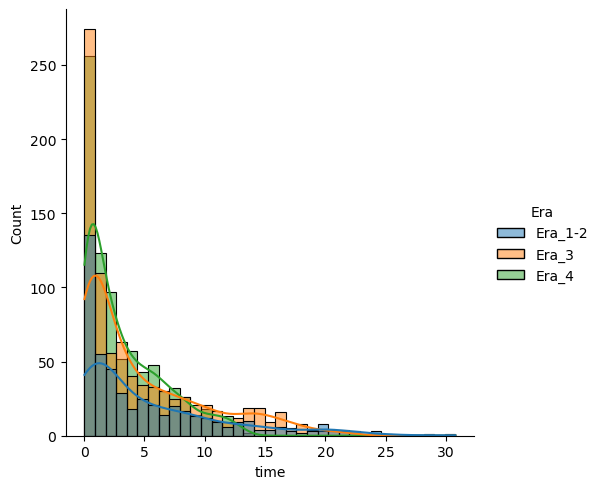

In [7]:
sns.displot(data=AL_df, x="time", hue="Era",kde=True)
plt.savefig("figures/TTE_by_era.pdf", dpi=200, bbox_inches="tight")

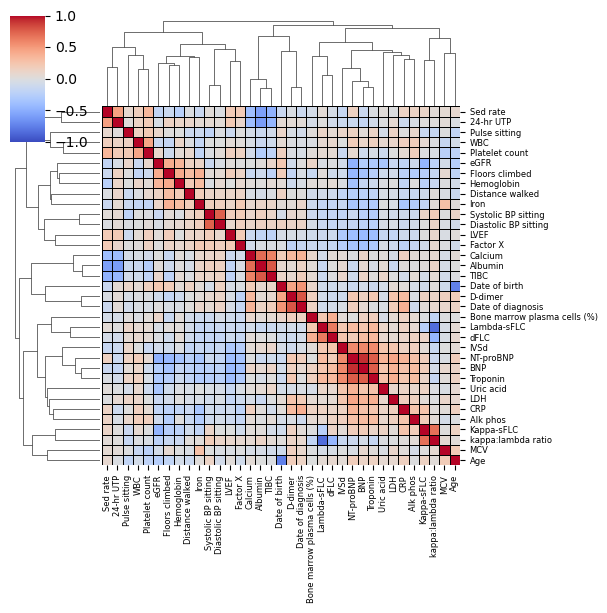

In [9]:
clustermap = sns.clustermap(
    AL_df[amyloid.qvars + ["Date of diagnosis","Date of birth"] + ['Age']].corr('spearman'),
    xticklabels=True,
    yticklabels=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linecolor='k',
    linewidths=0.5,
    figsize=(7,7),
    #col_label_kws={'fontsize': 12}
)

_ = clustermap.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xticklabels(), fontsize=6)
_ = clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), fontsize=6)

plt.savefig("figures/spearman_corr_clustermap.pdf", dpi=200, bbox_inches="tight")

In [10]:
missing_by_patient = 0.6
missing_by_var = 0.6

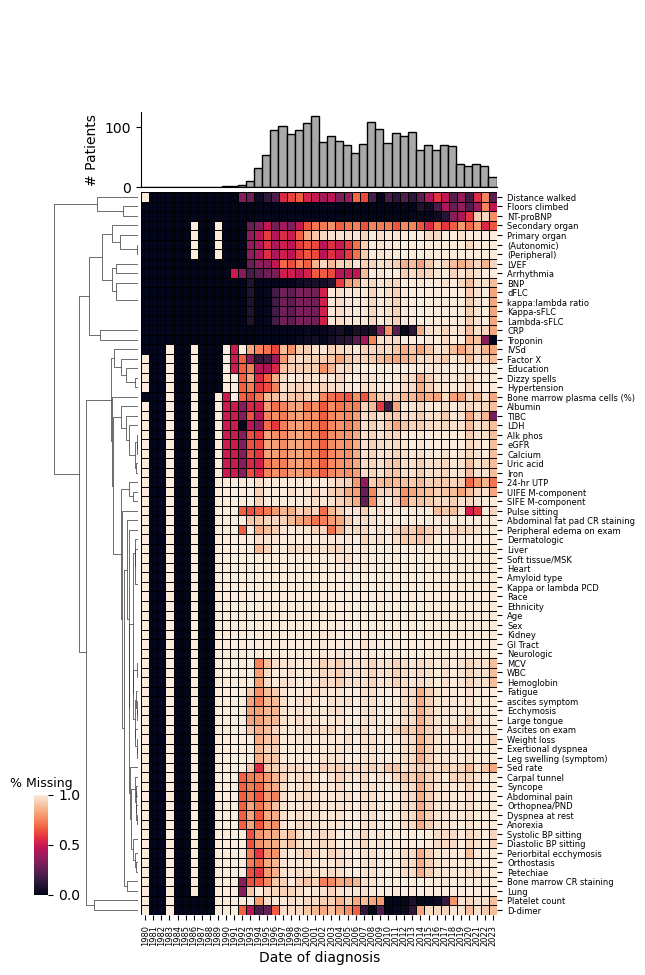

In [11]:
gb_date = "Date of diagnosis"

# Create proportion
df = AL_df[amyloid.qvars + amyloid.catvars].notna().join(AL_df[gb_date])
n_patients_per_year = df.groupby(pd.Grouper(key=gb_date, freq="Y")).size()
prop_df = df.groupby(pd.Grouper(key=gb_date, freq="Y")).sum().T / n_patients_per_year
prop_df = prop_df.T
prop_df.index = prop_df.reset_index()[gb_date].dt.year
prop_df = prop_df.fillna(0)

# Plot
clustermap = sns.clustermap(
    prop_df.T,
    xticklabels=True,
    yticklabels=True,
    linecolor='k',
    linewidths=0.5,
    figsize=(7,10),
    col_cluster=False,
    row_cluster=True
)
_ = clustermap.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xticklabels(), fontsize=6)
_ = clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), fontsize=6)

# Colorbar
cbar_ax = clustermap.ax_cbar
cbar_ax.set_position([0, .1, .02, .1])  # Adjust the position and size of the colorbar
cbar_ax.set_title("% Missing", fontsize=9)

# Barplot
bar_ax = clustermap.fig.add_axes([
    clustermap.ax_heatmap.get_position().x0,
    clustermap.ax_heatmap.get_position().y1 + 0.005,
    clustermap.ax_heatmap.get_position().x1*0.7675,
    0.075]) 

#bar_ax = clustermap.ax_heatmap.twinx()
n_patients_per_year.plot(kind='bar', width=1, edgecolor='k', ax=bar_ax, color='darkgrey')
bar_ax.set_xticks([])
bar_ax.set_xlabel("")
bar_ax.set_ylabel("# Patients")
bar_ax.spines['right'].set_visible(False)
bar_ax.spines['top'].set_visible(False)
bar_ax.set_xlim(-0.5, n_patients_per_year.shape[0] - 0.5)
plt.savefig("figures/missing_by_dateofdiagnosis.pdf", dpi=200, bbox_inches="tight")


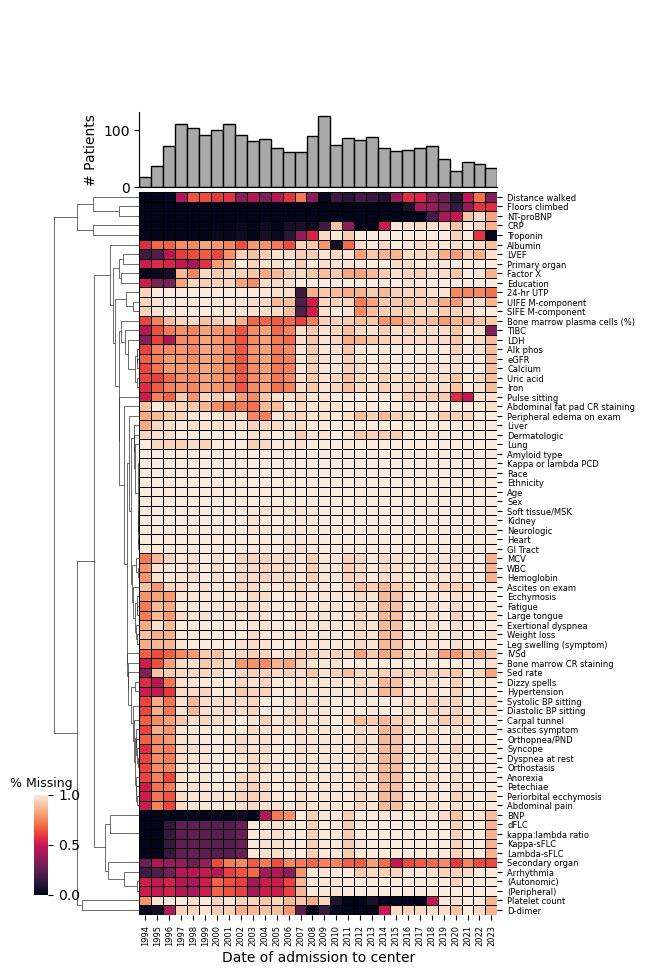

In [12]:
gb_date = "Date of admission to center"

# Create proportion
df = AL_df[amyloid.qvars + amyloid.catvars].notna().join(AL_df[gb_date])
n_patients_per_year = df.groupby(pd.Grouper(key=gb_date, freq="Y")).size()
prop_df = df.groupby(pd.Grouper(key=gb_date, freq="Y")).sum().T / n_patients_per_year
prop_df = prop_df.T
prop_df.index = prop_df.reset_index()[gb_date].dt.year
prop_df = prop_df.fillna(0)

# Plot
clustermap = sns.clustermap(
    prop_df.T,
    xticklabels=True,
    yticklabels=True,
    linecolor='k',
    linewidths=0.5,
    figsize=(7,10),
    col_cluster=False,
    row_cluster=True
)
_ = clustermap.ax_heatmap.set_xticklabels(clustermap.ax_heatmap.get_xticklabels(), fontsize=6)
_ = clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), fontsize=6)

# Colorbar
cbar_ax = clustermap.ax_cbar
cbar_ax.set_position([0, .1, .02, .1])  # Adjust the position and size of the colorbar
cbar_ax.set_title("% Missing", fontsize=9)

# Barplot
bar_ax = clustermap.fig.add_axes([
    clustermap.ax_heatmap.get_position().x0,
    clustermap.ax_heatmap.get_position().y1 + 0.005,
    clustermap.ax_heatmap.get_position().x1*0.773,
    0.075]) 

#bar_ax = clustermap.ax_heatmap.twinx()
n_patients_per_year.plot(kind='bar', width=1, edgecolor='k', ax=bar_ax, color='darkgrey')
bar_ax.set_xticks([])
bar_ax.set_xlabel("")
bar_ax.set_ylabel("# Patients")
bar_ax.spines['right'].set_visible(False)
bar_ax.spines['top'].set_visible(False)
bar_ax.set_xlim(-0.5, n_patients_per_year.shape[0] - 0.5)
plt.savefig("figures/missing_by_dateofadmission.pdf", dpi=200, bbox_inches="tight")

/var/folders/m0/69jv0yz94wd23rxxdwwkcn9w0000gp/T/ipykernel_93073/2582044434.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=8)
/var/folders/m0/69jv0yz94wd23rxxdwwkcn9w0000gp/T/ipykernel_93073/2582044434.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts = [axes[1].text(df['cv'][i], df[0][i], df.index[i], ha='center', va='center', fontsize=5) for i in range(df.shape[0])]


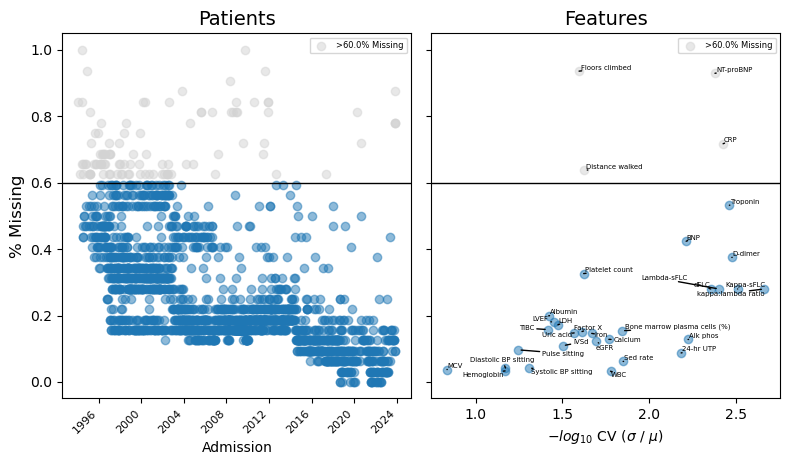

In [13]:
from adjustText import adjust_text

fig,axes = plt.subplots(1,2,figsize=(8,4.75), sharey=True)

# Patient Missing Scatterplot
df = AL_df[amyloid.qvars]
df = pd.DataFrame(df.isna().sum(1) / df.shape[1]).sort_values(0).join(AL_df['Date of admission to center'])

df_1 = df[df[0]<=missing_by_patient]
df_2 = df[df[0]>missing_by_patient]

axes[0].scatter(df_1['Date of admission to center'], df_1[0], alpha=0.5, rasterized=True)
axes[0].scatter(df_2['Date of admission to center'], df_2[0], alpha=0.5, c='lightgrey', label=">{}% Missing".format(missing_by_patient*100), rasterized=True)
axes[0].set_xlabel("Admission")
axes[0].set_ylabel("% Missing", fontsize=12)
axes[0].axhline(missing_by_patient, linewidth=1, c='k')
axes[0].legend(fontsize=6)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=8)
axes[0].set_title("Patients", fontsize=14)

# Feature Missing Scatterplot
df = AL_df[amyloid.qvars]
df = pd.DataFrame(df.isna().sum(0) / df.shape[0]).sort_values(0).join(
    pd.DataFrame(df.mean(0), columns=['mean'])).join(
    pd.DataFrame(df.std(0), columns=['std']))

df['cv'] = 100 * (df['std'] / df['mean'])
df['cv'] = np.log10(df['cv'])

df_1 = df[df[0] <= missing_by_var]
df_2 = df[df[0] > missing_by_var]

axes[1].scatter(df_1['cv'], df_1[0], alpha=0.5, rasterized=True)
axes[1].scatter(df_2['cv'], df_2[0], alpha=0.5, c='lightgrey', label=">{}% Missing".format(missing_by_var*100), rasterized=True)
axes[1].set_xlabel("$-log_{10}$ CV ($\sigma$ / $\mu$)")
#axes[1].set_ylabel("% Missing")
axes[1].axhline(missing_by_var, linewidth=1, c='k')
axes[1].legend(fontsize=6)

texts = [axes[1].text(df['cv'][i], df[0][i], df.index[i], ha='center', va='center', fontsize=5) for i in range(df.shape[0])]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

axes[1].set_title("Features", fontsize=14)
plt.tight_layout()
plt.savefig("figures/missing_vars_scatterplot.svg", dpi=200, bbox_inches="tight")


In [14]:
# Filter Quantitative Variables
qvars_to_keep = (AL_df[amyloid.qvars].isna().sum() / AL_df.shape[0] <= missing_by_var)
qvars_to_keep = list(qvars_to_keep[qvars_to_keep].index)

# Filter patients
patients_to_keep = (AL_df[amyloid.qvars].isna().sum(1) / len(amyloid.qvars) <= missing_by_patient)

print("Filtered {} > {} patient samples.".format(AL_df.shape[0], patients_to_keep.sum()))
print("Filtered {} > {} quantitaitve variables.".format(len(amyloid.qvars), len(qvars_to_keep)))

Filtered 2176 > 2074 patient samples.
Filtered 32 > 28 quantitaitve variables.


In [15]:
AL_filt_df = AL_df.loc[patients_to_keep,:]

In [17]:
# Only include categorical and continuous variables and dependent variables
vars_for_imputation = amyloid.catvars + qvars_to_keep + ['time','status']

In [17]:
AL_filt_df[vars_for_imputation].rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR, "AL_for_imputation_01.tsv"), sep='\t')

# Continuous variables and dependent variables
AL_filt_df[qvars_to_keep].rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR, "AL_for_ccp_02.tsv"), sep='\t')

#### Testing for subsets
---

In [80]:
# Subset fo ryears
# Missing decades w/ platelet count and d-dimer
vars_sub_for_imputation = np.setdiff1d(vars_for_imputation, ["Platelet count","D-dimer"])
qvars_sub_to_keep = np.setdiff1d(qvars_to_keep, ["Platelet count","D-dimer"])

In [81]:
### Subset for years where we have troponin
AL_filt_subset2004_df = AL_filt_df.loc[AL_filt_df["Date of admission to center"]>"01/01/2004",:]

print("{} patients admitted in 2004 or later.".format(AL_filt_subset2004_df.shape[0]))
s = AL_filt_subset2004_df[vars_sub_for_imputation].isna().sum().sort_values(ascending=False) / AL_filt_subset2004_df[vars_sub_for_imputation].shape[0]
s.head(10)

1327 patients admitted in 2004 or later.


Secondary organ                 0.310475
Troponin                        0.239638
Bone marrow plasma cells (%)    0.170309
UIFE M-component                0.162773
Albumin                         0.144687
Arrhythmia                      0.128109
24-hr UTP                       0.122080
SIFE M-component                0.121326
(Autonomic)                     0.085908
(Peripheral)                    0.084401
dtype: float64

In [82]:
# All vars for imputation
AL_filt_subset2004_df[vars_sub_for_imputation].rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR, "AL_2004_for_imputation_01.tsv"), sep='\t')

# Continuous variables and dependent variables
AL_filt_subset2004_df[qvars_sub_to_keep].rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR, "AL_2004_for_ccp_02.tsv"), sep='\t')

In [83]:
### Subset for years where we have troponin
AL_filt_subset2008_df = AL_filt_df.loc[AL_filt_df["Date of admission to center"]>"01/01/2008",:]

print("{} patients admitted in 2008 or later.".format(AL_filt_subset2008_df.shape[0]))
s = AL_filt_subset2008_df[vars_sub_for_imputation].isna().sum().sort_values(ascending=False) / AL_filt_subset2008_df[vars_sub_for_imputation].shape[0]
s.head(10)

1061 patients admitted in 2008 or later.


Secondary organ                 0.317625
UIFE M-component                0.140434
Albumin                         0.127238
Bone marrow plasma cells (%)    0.126296
24-hr UTP                       0.103676
SIFE M-component                0.097078
IVSd                            0.088596
LVEF                            0.084826
Troponin                        0.082941
Factor X                        0.074458
dtype: float64

In [84]:
# All vars for imputation
AL_filt_subset2008_df[vars_sub_for_imputation].rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR, "AL_2008_for_imputation_01.tsv"), sep='\t')

# Continuous variables and dependent variables
AL_filt_subset2008_df[qvars_sub_to_keep].rename(columns=amyloid.ddict_clean).to_csv(os.path.join(PROCESSED_DIR, "AL_2008_for_ccp_02.tsv"), sep='\t')